In [1]:
import random
import warnings
warnings.filterwarnings('ignore')
import neurokit2 as nk
import numpy as np
import pandas as pd
from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from datetime import timedelta
from datetime import datetime
import scipy
import matplotlib.pyplot as plt

In [2]:
def Insulin_Glucose_data(year,month,day,hour,minute,second):
         #specify start_time as the beginning of today
         dt = datetime(year,month,day,hour,minute,second)
         start_time = datetime.combine(dt.date(), datetime.min.time())
         # --------- Create Random Scenario --------------
         # Specify results saving path
         path = './results'
        # Create a simulation environment
         patient = T1DPatient.withName('adolescent#001')
         sensor = CGMSensor.withName('Dexcom', seed=1)
         pump = InsulinPump.withName('Insulet')
         scenario = RandomScenario(start_time=start_time, seed=1)
         env = T1DSimEnv(patient, sensor, pump, scenario)

        # Create a controller
         controller = BBController()

        # Put them together to create a simulation object
         s1 = SimObj(env, controller, timedelta(days=7), animate=False, path=path)
         results1 = sim(s1)
         data2=pd.DataFrame(results1)
         data_glucose_insulin=data2[["CGM","insulin"]].reset_index()
         data_glucose_insulin_V2=data_glucose_insulin[:3000]
         data_glucose_insulin_V3=data_glucose_insulin_V2[["CGM","insulin"]]
         return data_glucose_insulin_V3

1.1 Glucose data visualisation

Process ID: 3860
Simulation starts ...
Simulation Completed!


(array([  7.,   5.,  11.,  16.,  37.,  68.,  77., 196., 147., 130., 154.,
        156., 136., 158., 158., 156., 167., 165., 158., 131., 142., 158.,
        139., 127.,  78.,  52.,  31.,  17.,  18.,   5.]),
 array([ 56.80487185,  61.01055167,  65.21623148,  69.4219113 ,
         73.62759111,  77.83327093,  82.03895074,  86.24463056,
         90.45031037,  94.65599019,  98.86167   , 103.06734981,
        107.27302963, 111.47870944, 115.68438926, 119.89006907,
        124.09574889, 128.3014287 , 132.50710852, 136.71278833,
        140.91846815, 145.12414796, 149.32982777, 153.53550759,
        157.7411874 , 161.94686722, 166.15254703, 170.35822685,
        174.56390666, 178.76958648, 182.97526629]),
 <BarContainer object of 30 artists>)

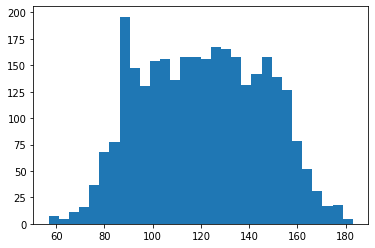

In [6]:
data=Insulin_Glucose_data(2022,9,19,12,0,0)
plt.hist(data["CGM"],bins=30)

1.2 Glucose Data Distribution Modeling

In [30]:
import scipy.stats as stats
distribution_names = ['norm', 'beta','gamma','alpha','pareto', 't', 'lognorm', 'invgamma', 'invgauss',  'loggamma', 'chi', 'chi2','uniform']
sse = np.inf
sse_thr = 0.10
y, x = np.histogram(data["CGM"], bins=500, density=True)
# Pour chaque distribution
x = (x + np.roll(x, -1))[:-1] / 2.0
sum_square_error=[]
p_value=[]
sse = np.inf
sse_thr = 0.10

# Pour chaque distribution
for name in distribution_names:

	# Modéliser
	dist = getattr(scipy.stats, name)
	param = dist.fit(data["CGM"])

	# Paramètres
	loc = param[-2]
	scale = param[-1]
	arg = param[:-2]

	# PDF
	pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
	# SSE
	model_sse = np.sum((y - pdf)**2)

	# Si le SSE est ddiminué, enregistrer la loi
	if model_sse < sse :
		best_pdf = pdf
		sse = model_sse
		best_loc = loc
		best_scale = scale
		best_arg = arg
		best_name = name

	# Si en dessous du seuil, quitter la boucle
	if model_sse < sse_thr :
		break
print("Selected Model : ", best_name)
print("Loc. param. : ", best_loc)
print("Scale param. : ", best_scale)
print("Other arguments : ", best_arg)
print("SSE : ", sse)


Selected Model :  norm
Loc. param. :  120.94377803525127
Scale param. :  25.16495766182926
Other arguments :  ()
SSE :  0.009404495613880267


2.1 insulin data visualisation

(array([2.978e+03, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00]),
 array([0.01393333, 0.09356306, 0.17319278, 0.2528225 , 0.33245222,
        0.41208194, 0.49171167, 0.57134139, 0.65097111, 0.73060083,
        0.81023056, 0.88986028, 0.96949   , 1.04911972, 1.12874944,
        1.20837917, 1.28800889, 1.36763861, 1.44726833, 1.52689806,
        1.60652778, 1.6861575 , 1.76578722, 1.84541694, 1.92504667,
        2.00467639, 2.08430611, 2.16393583, 2.24356556, 2.32319528,
        2.402825  ]),
 <BarContainer object of 30 artists>)

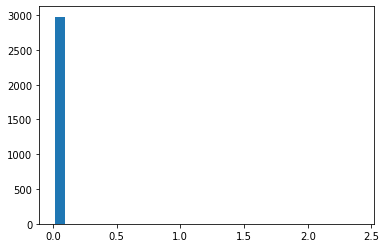

In [9]:
plt.hist(data["insulin"],bins=30)

2.2 insulin data distribution modeling

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
halflogistic,118.614898,19567.759982,-9675.443692,inf,0.992660,0.0
genhalflogistic,119.953050,19512.466988,-9633.782343,inf,0.992665,0.0
expon,131.756490,19646.914854,-9360.223638,inf,0.992667,0.0
genexpon,131.756623,19652.862630,-9336.201491,inf,0.992667,0.0
laplace_asymmetric,131.760302,19647.355122,-9352.130462,inf,0.992667,0.0


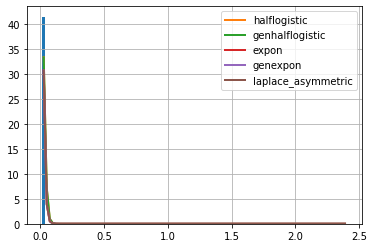

In [12]:
from fitter import Fitter
f = Fitter(data['insulin'])
f.fit()
f.summary()

In [24]:

dist_name = "expon"

# Paramètres de la loi
dist = getattr(scipy.stats, dist_name)

# Modéliser la loi
param = dist.fit(data["insulin"])
print(param)

(0.013933333333333336, 0.01163401666666666)


[0.01459908 0.04417364 0.04569709 ... 0.03468879 0.02576572 0.01986093]


(array([1.866e+03, 7.510e+02, 2.600e+02, 7.500e+01, 2.800e+01, 1.000e+01,
        5.000e+00, 2.000e+00, 1.000e+00, 2.000e+00]),
 array([0.01393338, 0.02526543, 0.03659749, 0.04792955, 0.0592616 ,
        0.07059366, 0.08192571, 0.09325777, 0.10458982, 0.11592188,
        0.12725393]),
 <BarContainer object of 10 artists>)

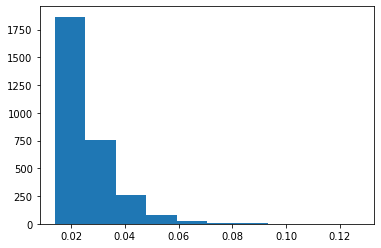

In [25]:
from scipy.stats import expon
data_insulin= expon.rvs(size=3000, loc=0.013933333333333336, scale=0.01163401666666666)
print(data_insulin)
plt.hist(data_insulin)

3.1 Data Generation: Body temperature, RSP, ECG

In [57]:
def temperature_data(nb_samples,etat_patient):
        lst=[]
        if etat_patient=='N':
            temp_min=36
            temp_max=37
            j=temp_min
            for j in range(temp_min,temp_max+1):
                 d='%d'%j+'.'+'%d'%random.randint(100,999)
                 lst+=[float(d)]
                 for i in range (nb_samples//2):
                    d='36.%d'%random.randint(100,999)
                    lst+=[float(d)]
        if etat_patient=='EF':
            for i in range(nb_samples):
                d='37.%d'%random.randint(800,900)
                lst+=[float(d)]
        if etat_patient=="AF":
            temp_max=36
            temp_min=28
            for i in range(temp_max,temp_min-1,-1):
                for j in range(nb_samples//(temp_max-temp_min)):
                    d='%d'%i+'.'+'%d'%random.randint(100,999)
                    lst+=[float(d)]
        if etat_patient=="AC":
             temp_max=44
             temp_min=37
             for i in range(temp_min,temp_max+1):
                  for j in range(nb_samples//(temp_max-temp_min)):
                       d='%d'%i+'.'+'%d'%random.randint(100,999)
                       lst+=[float(d)]   
        return lst[:nb_samples]

In [34]:
def ECG_data(nb_samples):
    Simulated_ECG=nk.ecg_simulate(duration=20, sampling_rate=nb_samples//20,noise=0.01, heart_rate=100)
    return Simulated_ECG[:nb_samples]
  

In [58]:
def RSP_data(nb_samples):
    rsp_sim = nk.rsp_simulate(duration=15, sampling_rate=200,noise=0.01,respiratory_rate=100, method="sinusoidal")
    return rsp_sim[:nb_samples]

3.2 DataBase construction

In [63]:
def data_generation(n_patients):
    temp=[]
    for i in range (n_patients):
        etat_patient=random.choice(["N","AC","AF","EF"])
        a=temperature_data(180,etat_patient)   # we gonna consider the mean of every tree minute 180=60*3
        temp.append(sum(a)/len(a))
    data = pd.DataFrame(
        {"ECG_moy_of_patients":ECG_data(n_patients),
         "RSP_moy_of_patients":RSP_data(n_patients),
         "body_temp_moy_of_patients":temp,
         "CGM_moy_of_patients":stats.norm.rvs(120.94377803525127, 25.16495766182926, size=n_patients),
         "insulin_moy_of_patients":expon.rvs(size=n_patients, loc=0.013933333333333336, scale=0.01163401666666666)})
    return data

In [64]:
data_generation(1000)

,ECG_moy_of_patients,RSP_moy_of_patients,body_temp_moy_of_patients,CGM_moy_of_patients,insulin_moy_of_patients
0,1.125068,-0.003339,32.938072,125.787288,0.014714
1,0.084636,0.022977,36.548889,127.347363,0.018767
2,-0.298318,0.049498,32.970567,134.754444,0.034160
3,-0.065227,0.076128,40.650567,162.854092,0.020366
4,-0.011523,0.102768,32.955833,113.928850,0.028525
...,...,...,...,...,...
995,-0.028114,0.479524,32.930067,145.414345,0.022066
996,0.043527,0.472823,37.849972,114.558492,0.046958
997,0.144992,0.464815,32.942483,87.681283,0.021684
998,0.259149,0.455512,37.849206,93.297844,0.018440


3.3 Preparation for the model

In [65]:
data=data_generation(1000)
data['scale'] = (
        data.ECG_moy_of_patients + 
        data.RSP_moy_of_patients + 
        2*data.body_temp_moy_of_patients+
        2*data.CGM_moy_of_patients+
        2*data.insulin_moy_of_patients)

(array([ 1.,  0.,  1.,  0.,  0.,  1.,  3.,  0.,  1.,  1.,  1.,  2.,  3.,
         4.,  0.,  0.,  3.,  7.,  8.,  7.,  8.,  8.,  8.,  8., 11., 16.,
         8., 14., 15., 24., 20., 20., 21., 17., 23., 28., 22., 29., 23.,
        31., 24., 21., 34., 27., 32., 25., 19., 20., 22., 30., 22., 23.,
        31., 25., 16., 20., 17., 15., 15., 19., 13., 21., 17., 19., 11.,
         9.,  9.,  5.,  7.,  7.,  5.,  2.,  4.,  4.,  1.,  3.,  0.,  0.,
         1.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([156.68945483, 160.2811956 , 163.87293636, 167.46467713,
        171.05641789, 174.64815866, 178.23989942, 181.83164019,
        185.42338095, 189.01512172, 192.60686248, 196.19860325,
        199.79034401, 203.38208478, 206.97382555, 210.56556631,
        214.15730708, 217.74904784, 221.34078861, 224.93252937,
        228.52427014, 232.1160109 , 235.70775167, 239.29949243,
        242.8912332 , 246.48297396, 250.07471473, 

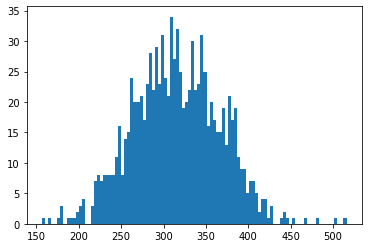

In [67]:
plt.hist(data['scale'],bins=100)

In [74]:
# 0 :normale state 
# 1 : anormale state
data["status"]=data["scale"].apply(
    lambda x: 0 if (250 <= x <= 380) 
    else 1

    )


In [75]:
data

,ECG_moy_of_patients,RSP_moy_of_patients,body_temp_moy_of_patients,CGM_moy_of_patients,insulin_moy_of_patients,scale,status
0,1.119547,0.010207,32.960039,123.106917,0.020987,313.305638,0
1,0.055930,0.036362,32.999750,142.172977,0.066584,350.570914,0
2,-0.348475,0.062423,37.846522,120.435746,0.020607,316.319699,0
3,-0.108034,0.088318,37.850028,121.720228,0.017658,319.156112,0
4,-0.051763,0.113980,32.918778,158.887864,0.028596,383.732693,1
...,...,...,...,...,...,...,...
995,0.060049,0.471805,37.847839,120.811930,0.060119,317.971631,0
996,0.173048,0.463569,32.956789,168.575517,0.020198,403.741625,1
997,0.283361,0.454068,36.527878,103.490695,0.042421,280.859416,0
998,0.348029,0.443341,36.550956,115.821966,0.021058,305.579329,0


In [79]:
data["status"].value_counts()

0    786
1    214
Name: status, dtype: int64

In [80]:
#visualisation de pourcentage de la distribution
data['status'].value_counts()/np.float(len(data["status"]))

0    0.786
1    0.214
Name: status, dtype: float64

In [83]:
from sklearn.model_selection import train_test_split
X = data.drop(['status'], axis=1)
y = data['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

3.4 Model Construction

In [85]:
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


# instantiate classifier with default hyperparameters
svc=SVC() 


# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.9700


In [98]:
# instantiate classifier with rbf kernel and C=100
model_svc=SVC(C=100.0) 


# fit classifier to training set
model_svc.fit(X_train,y_train)


# make predictions on test set
y_pred=model_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=100.0 : 0.9800


In [95]:
model_svc.get_params()

{'C': 100.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}